# Recommender System - Neural Network

The recommender here use the RMSE loss function.

## 1. Prerequisites

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import scipy
import scipy.io
import scipy.sparse as sp
import keras

warnings.filterwarnings('ignore')
%matplotlib inline


from sklearn.preprocessing import LabelEncoder
from keras import layers
from keras import models
from keras import optimizers

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
from helpersNeuralNet import load_data
from sklearn.model_selection import train_test_split

DATA_TRAIN_PATH = "data/data_train.csv"
ratings = load_data(DATA_TRAIN_PATH)

DATA_TEST_PATH = "data/sampleSubmission.csv"
samples = load_data(DATA_TEST_PATH)

n_users = len(ratings.user_id.unique())
n_items = len(ratings.movie_id.unique())

In [3]:
samples.head()

,user_id,movie_id,rating
0,37,1,3
1,73,1,3
2,156,1,3
3,160,1,3
4,248,1,3


## 2. Data preprocessing

In [4]:
from sklearn import model_selection

train_x, test_x = model_selection.train_test_split(ratings, test_size=0.2, random_state=1)

In [5]:
categorical_train_y = np.zeros([train_x.shape[0], 5])
categorical_train_y[np.arange(train_x.shape[0]), train_x.rating - 1] = 1
categorical_train_y.shape

categorical_test_y = np.zeros([test_x.shape[0], 5])
categorical_test_y[np.arange(test_x.shape[0]), test_x.rating - 1] = 1
categorical_test_y.shape

(235391, 5)

## 3. Neural network

In [6]:
from keras.optimizers import Adam
from keras.regularizers import l2
from keras_radam import RAdam

def shallow_net():
    features = 48
    
    input_i = layers.Input(shape=[1])
    i = layers.Embedding(n_items + 1, features)(input_i)
    i = layers.Flatten()(i)
    i = layers.normalization.BatchNormalization()(i)

    input_u = layers.Input(shape=[1])
    u = layers.Embedding(n_users + 1, features)(input_u)
    u = layers.Flatten()(u)
    u = layers.normalization.BatchNormalization()(u)
    
    nn = layers.concatenate([i, u])
    
    nn = layers.Dense(512, activation='relu')(nn)
    nn = layers.Dropout(0.5)(nn)
    nn = layers.normalization.BatchNormalization()(nn)
    
    nn = layers.Dense(128, activation='relu')(nn)
    
    output = layers.Dense(5, activation='softmax')(nn)
    
    model = models.Model([input_i, input_u], output)
    model.compile(optimizer='adamax', loss='categorical_crossentropy')
    return model

# Optimizer : 'adamax', 'sgd', 'adam', RAdam()

In [16]:
def dense_net():
    features = 256
    
    input_i = layers.Input(shape=[1])
    i = layers.Embedding(n_items + 1, features)(input_i)
    i = layers.Flatten()(i)
    i = layers.normalization.BatchNormalization()(i)

    input_u = layers.Input(shape=[1])
    u = layers.Embedding(n_users + 1, features)(input_u)
    u = layers.Flatten()(u)
    u = layers.normalization.BatchNormalization()(u)
    
    nn = layers.concatenate([i, u])
    
    nn = layers.Dense(512, activation='relu')(nn)
    nn = layers.normalization.BatchNormalization()(nn)
#     nn = layers.Dropout(0.5)(nn)
    nn = layers.Dense(512, activation='relu')(nn)
    
    output =  layers.Dense(5, activation='softmax')(nn)
    
    model = models.Model([input_i, input_u], output)
    model.compile(optimizer='adamax', loss='categorical_crossentropy')
    return model

In [8]:
def deep_net():
    features = 48
    
    input_i = layers.Input(shape=[1])
    i = layers.Embedding(n_items + 1, features)(input_i)
    i = layers.Flatten()(i)
    i = layers.normalization.BatchNormalization()(i)

    input_u = layers.Input(shape=[1])
    u = layers.Embedding(n_users + 1, features)(input_u)
    u = layers.Flatten()(u)
    u = layers.normalization.BatchNormalization()(u)
    
    nn = layers.concatenate([i, u])
    
    nn = layers.Dense(1024, activation='relu')(nn)
    nn = layers.Dropout(0.5)(nn)
    nn = layers.normalization.BatchNormalization()(nn)
    nn = layers.Dense(512, activation='relu')(nn)
    nn = layers.Dropout(0.5)(nn)
    nn = layers.normalization.BatchNormalization()(nn)
    nn = layers.Dense(256, activation='relu')(nn)
    nn = layers.Dropout(0.5)(nn)
    nn = layers.normalization.BatchNormalization()(nn)
    nn = layers.Dense(128, activation='relu')(nn)
    
    output = layers.Dense(5, activation='softmax')(nn)
    
    model = models.Model([input_i, input_u], output)
    model.compile(optimizer='adamax', loss='categorical_crossentropy')
    
    return model

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 256)       256256      input_9[0][0]                    
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 256)       2560256     input_10[0][0]                   
____________________________________________________________________________________________

Text(0, 0.5, 'Test Error')

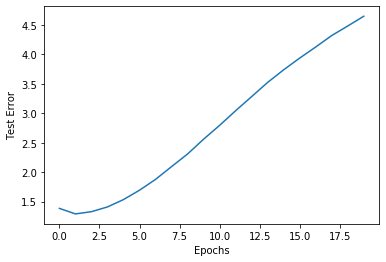

In [17]:
model = dense_net()
model.summary()

history = model.fit([train_x.movie_id, train_x.user_id], y=categorical_train_y,  batch_size=2048, epochs=20, validation_data=([test_x.movie_id, test_x.user_id], categorical_test_y))
model.save('NeuralNet_base.h5')
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Test Error")

### 5.2 Model validation

In [10]:
model.evaluate([test_x.movie_id, test_x.user_id], categorical_test_y)

235391/235391 [==============================] - 11s 48us/step


1.5982267639283312

In [26]:
from sklearn.metrics import mean_squared_error

pred_test_matrix = model.predict([test_x.movie_id, test_x.user_id])

pred_test = (np.dot(pred_test_matrix,[1,2,3,4,5])).tolist()

In [27]:
for i in range(len(pred_test)):
#     pred[i] = np.round(pred[i])
    if (pred_test[i] < 1):
        pred_test[i] = 1
    elif (pred_test[i] > 5):
        pred_test[i] = 5

In [33]:
test_x['NN_dense_rating'] = pred_test
test_x

,user_id,movie_id,rating,NN_shallow_rating
1014743,1219,803,5,3.642172
791571,1865,643,1,4.470908
967641,1382,771,3,3.038107
65567,3295,53,3,3.648969
622228,9259,530,4,4.012660
...,...,...,...,...
468443,2110,403,5,3.727260
1064490,9211,855,2,2.812773
1172922,7228,996,3,3.449689
327551,9827,272,5,3.998318


In [34]:
DATA_BLENDING_TEST = "data/neuralnet_dense_test.csv"
test_x.to_csv(DATA_BLENDING_TEST)

### Create submission

In [30]:
pred_matrix = model.predict([samples.movie_id, samples.user_id])

In [31]:
pred_samples = (np.dot(pred_matrix,[1,2,3,4,5])).tolist()

In [35]:
for i in range(len(pred_samples)):
#     pred[i] = np.round(pred[i])
    if (pred_samples[i] < 1):
        pred_samples[i] = 1
    elif (pred_samples[i] > 5):
        pred_samples[i] = 5

In [36]:
submission = load_data(DATA_TEST_PATH)
submission['NN_dense_rating'] = pred_samples
submission

,user_id,movie_id,rating,NN_shallow_rating
0,37,1,3,3.425436
1,73,1,3,3.173776
2,156,1,3,3.573101
3,160,1,3,3.092145
4,248,1,3,3.672881
...,...,...,...,...
1176947,9974,1000,3,3.815011
1176948,9977,1000,3,3.209673
1176949,9978,1000,3,2.180135
1176950,9982,1000,3,2.662641


In [37]:
DATA_BLENDING_SUBMISSION = "data/neuralnet_dense_submission.csv"
submission.to_csv(DATA_BLENDING_SUBMISSION)